# Analysis of trial-based photometry data

This notebook illustrates methods for analysing fiber photometry data from behavioural tasks with a discrete trial structure.  The repository contains an example dataset consisting of 5 sessions each from 9 subjects perfoming a probabilistic reversal learning task, with dLight photometry recordings in the dorsolateral striatum.  The experiment was run using [pyControl](https://pycontrol.readthedocs.io) to implement the behavioural task and [pyPhotometry](https://pyphotometry.readthedocs.io) to aquire the photometry signals.  The repository structure is:

```
photometry_analysis_repository
├── code
    ├── photometry_analysis.ipynb  # This notebook.
    ├── analysis                   # 
├── data
    ├── processed                
        ├── subject                # Data folder for one subject.
            ├── session            # Data folder for one session
```
The data files in the processed data folder are not the raw data output by the experimental hardware, but rather have been preprocessed and organised to represent the data using only generic file types containing simple data stutures.  We use `.npy` ([Numpy](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)) files for arrays of numerical data, `.htsv` ([tab-seperated value](https://en.wikipedia.org/wiki/Tab-separated_values) with header) files for tables of hetrogenous data, and `.json` ([JSON](https://www.json.org/json-en.html)) files for dictionaries of key-value pairs.  The photometry data has already been pre-processed to correct for photobleaching and remove movement artifacts, using methods detailed in the [photometry-preproccessing](https://github.com/ThomasAkam/photometry_preprocessing) notebook.  The photometry data has been synchronised with the behavioural data such that all time measurements are in seconds since the start of the behavioural session.  The data organisation and pre-processing pipeline used to generate the data in this repository from the raw pyControl and pyPhotometry data files is detailed in the [data organisation](https://github.com/cognitive-circuits/data_organisation/) repository.

Each session's data folder contains the following files:

- `session_info.json` A dictionary with information about the session including the subject ID, start date-time, end date-time, etc.

- `events.htsv` Table containing behavioural task state entries and events, with one row per state entry/event, with columns *time*, *type* (state or event) and *name*.

- `trials.htsv` Table with one row per trial of the behavioural task containing information about what happened on the trial and the times of trial events.

- `variables.json` Dictionary with the values of task variables at the end of the session.

- `photometry_info.json` Information about the photometry recordings including acqusition mode, sampling rate, LED current and recording hemisphere.

- `dlight.signal.npy` The pre-processed photometry signal after photobleaching and movement correction.

- `dlight.times.npy` The times of the photometry signal samples in seconds since the start of the behavioural session.

The analysis pipeline makes heavy use of [Pandas](https://pandas.pydata.org/) dataframes, as they are a fantastic tool for representing complex datasets in a way that is easy to work with.  We use Pandas [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) to hierarchically organise columns by grouping related variables (e.g. different timepoints in the trial aligned photometry data). The code mostly takes a functional rather than object-oriented approach, eschewing custom classes with the exception of a `Session` class which handles loading the various individual files that comprise a session's data, and storing them on the Session object for easy access.

The data structure which will ultimately be used for analyses is a Pandas dataframe containing data from all sessions, where each row corresponds to one trial.  The dataframe columns contain 3 types of information:

- Information about the session the trials came from, including subject ID, session date-time etc.
- Information about the behavioural events that happened on that trial, e.g. the subjects choice and trial outcome, and variables derived from these that will be used e.g as predictors in regression analyses.
- The photometry signal aligned to trial events of interest.

Two types of analysis are implemented in this notebook:

- Plotting average trial-event aligned photometry signals for a set of trial types defined by one or more behavioural variables, e.g. the choice and outcome, with cross-subject standard errors.
- A time-resolved linear regression analysis for characterising when (in the trial) and how different behaioural variables explain variance in the photometry signal.  This is implemented by running a seperate linear regression for each timepoint in the event aligned data, to yield for each predictor a timecoure of beta weights indicating when and  in what direction the predictor explained variance in the signal.  Seperate regression analyses are run for each subject with the mean and cross subject standard error plotted.  Statistical significance of predictor loadings is assessed by comparing the cross-subject distribution of betas against 0, with False Discovery Rate multiple comparision correction for multiple timepoints.

The main steps of the analysis pipeline are:

1. Define the `Session` class used to load and store the processed data from an individual session, and use this to load the data from all sessions.
2. Extract the trial-event aligned photometry signals for each trial, and generate additional trial-by-trial variables needed for analysis.  These intermediate data structures are saved out in `data/analysis` to avoid having to regenerate them each time the data is analysed.
3. Combine the behavioural and trial-aligned photometry data from all sessions into a single dataframe.
4. Run analyses.

This notebook is intended as a tutorial and contains all the code used for the analysis pipeline.  However, in practice we would typically split the various function and class definitions across multiple smaller modules as this makes the code easier to maintain and reuse.  We have therefore also included a version of the code organised in this way in the `code/analysis` folder, and a script `analysis_script.py` that reproduces the steps in this notebook using these modules.

Code in this repository is formatted using the [Black](https://pypi.org/project/black/) code formatter.

In [1]:
# Imports
import json
import warnings
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import statsmodels.formula.api as smf
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
from pprint import pprint
from scipy.stats import ttest_1samp, false_discovery_control
from tqdm import tqdm

# Enable Black code formatting
import jupyter_black

jupyter_black.load(line_length=120)

# Paths
processed_data_dir = Path("..", "data", "processed")  # Folder where the processed data is located.
analysis_data_dir = Path("..", "data", "analysis")  # Folder where analysis data will be saved.

## Data import and Session class

We will first define some utility functions for loading and saving data, and the `Session`
class used to load and represent data from one session.

In [2]:
# Utiltiy functions for loading and saving data.


def save_json(data, file_path):
    """Read data to specified filepath as a json"""
    with open(file_path, "w") as f:
        return json.dump(data, f, indent=4)


def load_json(file_path):
    """Read a json file and return the contents"""
    with open(file_path, "r") as f:
        return json.load(f)


def save_multiindex_df(df, file_path):
    """For a dataframe df whose columns are two-level MultiIndex where the second level may be empty,
    convert columns to a standard Index using mapping:
        MultiIndex: ('level_1', 'level_2')  --> Index: 'level_1.level_2'
        MultiIndex: ('level_1', '')         --> Index: 'level_1'
    Then save the converted df as a tab-seperated value file with header.
    """
    df.columns = [".".join(col) if col[1] else col[0] for col in df.columns]
    df.to_csv(file_path, sep="\t", index=False)


def load_multiindex_df(file_path):
    """Load a MultiIndex dataframe saved by the above save_multiindex_df function."""
    df = pd.read_csv(file_path, sep="\t")
    df.columns = pd.MultiIndex.from_tuples([col.split(".") if "." in col else [col, ""] for col in df.columns])
    return df

In [3]:
# Classes for representing data from one session.


@dataclass
class Session_info:
    """Dataclass for representing session info."""

    path: str
    analysis_data_dir: Path
    session_id: str
    experiment_name: str
    task_name: str
    task_file_hash: str
    setup_id: str
    framework_version: str
    micropython_version: str
    subject: str
    start_time: datetime
    end_time: datetime
    day: int
    number: int
    genotype: str = None

    def __post_init__(self):
        """Convert date-time strings to datetime objects."""
        self.start_time = datetime.fromisoformat(self.start_time)
        self.end_time = datetime.fromisoformat(self.end_time)


@dataclass
class Photometry:
    """Dataclass for representing photometry data and info."""

    mode: str
    sampling_rate: int
    LED_current: list
    hemisphere: str
    signal: np.ndarray
    times: np.ndarray


class Session:
    """Class for loading and representing processed data from one session."""

    def __init__(self, data_dir):
        """Load processed data files from data_dir and instantiate Session object."""
        print(f"Loading session: {data_dir}")
        analysis_dir = Path(*[part if part != "processed" else "analysis" for part in data_dir.parts])
        self.info = Session_info(data_dir, analysis_dir, **load_json(Path(data_dir, "session_info.json")))
        self.variables = load_json(Path(data_dir, "variables.json"))
        self.events_df = pd.read_csv(Path(data_dir, "events.htsv"), sep="\t")
        self.trials_df = load_multiindex_df(Path(data_dir, "trials.htsv"))
        # Load photometry signals if available.
        if Path(data_dir, "dlight.signal.npy").exists():
            self.photometry = Photometry(
                signal=np.load(Path(data_dir, "dlight.signal.npy")),
                times=np.load(Path(data_dir, "dlight.times.npy")),
                **load_json(Path(data_dir, "photometry_info.json")),
            )
        else:
            self.photometry = None

    def get_analysis_df(self):
        """Load analysis data files and return a dataframe with one row per trial
        containing the trial variables and aligned signals."""
        assert (
            Path(self.info.analysis_data_dir, "trials.aligned_signal.parquet").exists()
            & Path(self.info.analysis_data_dir, "trials.analysis_variables.parquet").exists()
        ), f"Analysis data not found for session: {self.info.session_id}"
        trials_df = self.trials_df.copy()
        vars_df = pd.read_parquet(Path(self.info.analysis_data_dir, "trials.analysis_variables.parquet"))
        signals_df = pd.read_parquet(Path(self.info.analysis_data_dir, "trials.aligned_signal.parquet"))
        # Convert DataFrames to 3 level MultiIndex.
        trials_df.columns = pd.MultiIndex.from_tuples([(*col, "") for col in trials_df.columns])
        vars_df.columns = pd.MultiIndex.from_tuples([(col, "", "") for col in vars_df.columns])
        signals_df.columns = pd.MultiIndex.from_tuples([("aligned_signal", *col) for col in signals_df.columns])
        # Return concatenated dataframe.
        return pd.concat([trials_df, vars_df, signals_df], axis=1)


def load_sessions(processed_data_dir):
    """Load all sessions in directory with structure processed_data_dir/subject_dir/session_dir"""
    sessions = []
    for subject_dir in Path(processed_data_dir).iterdir():
        for session_dir in subject_dir.iterdir():
            sessions.append(Session(session_dir))
    return sessions

We will now use the `Session` class to import data from one session:

In [4]:
# Session data dir is processed_data_dir/subject_ID/session_datetime
session_path = Path(processed_data_dir, "01_C3T1_R", "2023-11-13-114533")
session = Session(data_dir=session_path)

Loading session: ..\data\processed\01_C3T1_R\2023-11-13-114533


Lets have a look at the `Session` object:

In [5]:
pprint(session.info)  # The contents of 'session_info.json'

Session_info(path=WindowsPath('../data/processed/01_C3T1_R/2023-11-13-114533'),
             analysis_data_dir=WindowsPath('../data/analysis/01_C3T1_R/2023-11-13-114533'),
             session_id='01_C3T1_R-2023-11-13-114533',
             experiment_name='Thomas\\LRRK2_photometry',
             task_name='Thomas\\reversal_learning',
             task_file_hash='2655257290',
             setup_id='Box 1',
             framework_version='2.0rc1',
             micropython_version='1.12',
             subject='01_C3T1_R',
             start_time=datetime.datetime(2023, 11, 13, 11, 45, 33, 943000),
             end_time=datetime.datetime(2023, 11, 13, 13, 15, 33, 906000),
             day=1,
             number=1,
             genotype='A')


(0.0, 20.0)

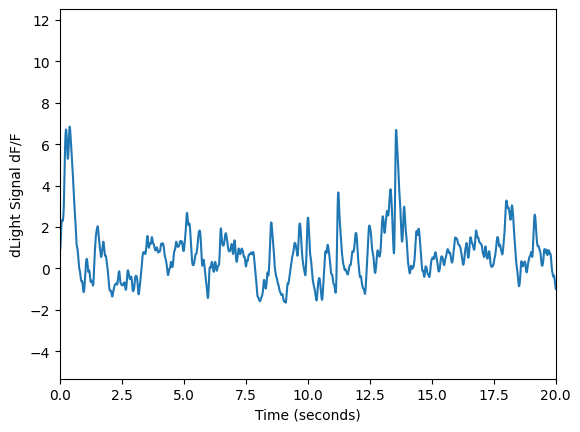

In [6]:
# Plot the first 20 seconds of the photometry signal.
plt.plot(session.photometry.times, session.photometry.signal)
plt.xlabel("Time (seconds)")
plt.ylabel("dLight Signal dF/F")
plt.xlim(0, 20)

In [7]:
session.events_df  # Contents of 'events.htsv' as a Dataframe with one row per event/state entry.

,time,type,name
0,0.000,state,initiation_state
1,0.002,event,poke_6
2,0.193,event,poke_6_out
3,0.387,event,poke_6
4,1.215,event,poke_6_out
...,...,...,...
5613,5126.992,event,poke_6_out
5614,5127.993,event,consumption_timer
5615,5127.993,state,inter_trial_interval
5616,5130.022,state,initiation_state


In [8]:
session.trials_df  # Contents of 'trials.htsv' as a Dataframe with one row per trial, information about trial events and times.

n_trials n_rewards n_blocks forced_choice good_poke  choice correct  \
                                                                          
0          1         0        0         False    poke_4  poke_6   False   
1          2         0        0         False    poke_4  poke_6   False   
2          3         1        0         False    poke_4  poke_4    True   
3          4         1        0          True    poke_4  poke_6   False   
4          5         1        0         False    poke_4  poke_4    True   
..       ...       ...      ...           ...       ...     ...     ...   
361      362       161        4         False    poke_4  poke_4    True   
362      363       161        4         False    poke_4  poke_4    True   
363      364       162        4          True    poke_4  poke_6   False   
364      365       162        4         False    poke_4  poke_6   False   
365      366       162        4          True    poke_4  poke_6   False   

    outcome   mov_ave threshold_crossed      times            
                                        initiation    choice  
0     False  0.441248             False      1.818     2.235  
1     False  0.389400             False      7.437     8.119  
2      True  0.461148             False     12.313    12.892  
3     False  0.461148             False     21.718    24.122  
4     False  0.524465             False     28.718    29.122  
..      ...       ...               ...        ...       ...  
361   False  0.532645             False   5092.642  5093.189  
362   False  0.587561             False   5097.695  5098.229  
363    True  0.587561             False   5103.012  5105.382  
364   False  0.518521             False   5120.997  5121.535  
365   False  0.518521             False   5125.403  5125.922  

[366 rows x 12 columns]

The `trials_df` dataframe uses a MultiIndex for the column names.  This is an index which has multiple levels (here two) allowing conceptually related data to be grouped together.  Here this is used for the times of two different trial events, with the top-level index for these columns being `time` and the second level being `intiation` and `choice` respectively.  The code below shows some ways of accessing data in a dataframe with MultiIndex columns.

In [9]:
session.trials_df.times.initiation  # Get the trial initation times column.

0         1.818
1         7.437
2        12.313
3        21.718
4        28.718
         ...   
361    5092.642
362    5097.695
363    5103.012
364    5120.997
365    5125.403
Name: initiation, Length: 366, dtype: float64

In [10]:
session.trials_df.times  # Get both times columns.

,initiation,choice
0,1.818,2.235
1,7.437,8.119
2,12.313,12.892
3,21.718,24.122
4,28.718,29.122
...,...,...
361,5092.642,5093.189
362,5097.695,5098.229
363,5103.012,5105.382
364,5120.997,5121.535


In [11]:
session.trials_df.outcome  # We can just specify the top-level index when the lower levels are empty.

0      False
1      False
2       True
3      False
4      False
       ...  
361    False
362    False
363     True
364    False
365    False
Name: outcome, Length: 366, dtype: bool

In [12]:
session.trials_df.loc[0, ("times", "choice")]  # Access one cell by specifying row and multi-index column.

2.235

In [13]:
session.trials_df.loc[0, "times"]  # Access both times column values from one row.

initiation    1.818
choice        2.235
Name: 0, dtype: object

We will now load the data for all sessions, using the `load_sessions` function defined above that iterates over subjects and sessions and returns a list of `Session` objects.

In [14]:
sessions = load_sessions(processed_data_dir)

Loading session: ..\data\processed\01_C3T1_R\2023-11-13-114533
Loading session: ..\data\processed\01_C3T1_R\2023-11-14-095006
Loading session: ..\data\processed\01_C3T1_R\2023-11-15-094032
Loading session: ..\data\processed\01_C3T1_R\2023-11-16-110916
Loading session: ..\data\processed\01_C3T1_R\2023-11-17-101622
Loading session: ..\data\processed\02_C3T2_R\2023-11-13-114533
Loading session: ..\data\processed\02_C3T2_R\2023-11-14-095007
Loading session: ..\data\processed\02_C3T2_R\2023-11-15-094032
Loading session: ..\data\processed\02_C3T2_R\2023-11-16-110916
Loading session: ..\data\processed\02_C3T2_R\2023-11-17-101623
Loading session: ..\data\processed\04_C1T3_L\2023-11-13-114534
Loading session: ..\data\processed\04_C1T3_L\2023-11-14-095007
Loading session: ..\data\processed\04_C1T3_L\2023-11-15-094032
Loading session: ..\data\processed\04_C1T3_L\2023-11-16-110917
Loading session: ..\data\processed\04_C1T3_L\2023-11-17-101623
Loading session: ..\data\processed\05_C1T4_R\2023-11-13

## Make analysis data

We now make some additional data structures that will be useful for analysis.  We do this by supplementing the trials dataframe with the trial aligned photometry signals, and additional variables that we will use for analysis.  

We will generate two different types of trial aligned signals:
1. Take time windows around trial events of interest.  We will do this for the trial initiation (when the subject nose-pokes a central port to initiate the trial) and choice (when subjects poke into a choice port and recieve the trial outcome).
2. Align signals across the whole trial by time-warping the signal to align multiple trial events to their median timing across trials.

In [15]:
def get_event_aligned_signal(session, trial_event, window_dur=[-2, 2]):
    """Extract the photometry signal on each trial around a specfied event and return as a
    Dataframe with MultiIndex columns where the 1st level is the event name and the 2nd level
    are times in seconds relative to the event.
    Arguments:
        session: Session object to be processed
        trial_event: Name of the event to extract signals around.
        window_dur = Duation of the window around the event specifing number of seconds before and after.
    Returns:
        aligned_signal_df: Dataframe with one row per trial containing the aligned signal.
    """
    window_len = (np.array(window_dur) * session.photometry.sampling_rate).astype(int)
    window_times = np.arange(*window_dur, 1 / session.photometry.sampling_rate)
    event_times = session.trials_df.times[trial_event].to_numpy()
    event_inds = np.searchsorted(session.photometry.times, event_times)
    aligned_signal = np.full((len(event_times), len(window_times)), np.nan)
    for i, (event_time, event_ind) in enumerate(zip(event_times, event_inds)):
        if np.isnan(event_time):
            continue
        else:
            event_window = event_ind + window_len
            if (event_window[0] < 0) or event_window[1] > len(session.photometry.signal):
                continue
            else:
                aligned_signal[i, :] = session.photometry.signal[event_window[0] : event_window[1]]
    aligned_signal_df = pd.DataFrame(aligned_signal, columns=window_times)
    # Make Multiindex with event name and time in window as levels.
    aligned_signal_df.columns = pd.MultiIndex.from_product([[trial_event], aligned_signal_df.columns])
    aligned_signal_df.columns.names = ["event", "time"]
    return aligned_signal_df


def align_signals(
    signals,
    sample_times,
    trial_times,
    target_times,
    pre_win=0,
    post_win=0,
    fs_out=25,
    smooth_SD="auto",
):
    """
    Timewarp continuous signals to align event times on each trial to specified target
    event times. For each trial, input sample times are linearly time warped to align
    that trial's event times with the target times.  Activity is then evaluated at a set of
    regularly spaced timepoints relative to the target event times by Gaussian smoothing
    around output timepoints. The pre_win and post_win arguments can be used to specify
    time windows before the first and after the last alignment event on each trial to be
    included in the output signals.

    Arguments:
        signals      : Signals to be aligned, either 1D [n_samples] or 2D [n_signals, n_samples]
        sample_times : Times when the samples occured (seconds) [n_samples]
        trial_times  : Times of events used for alignment for each trial (seconds) [n_trials, n_events]
        target_times : Times of events used for alignment in output aligned trial (seconds) [n_events].
        pre_win      : Time window before first event to include in aligned signals (seconds).
        post_win     : Time window after last event to include in aligned signals (seconds).
        fs_out       : The sampling rate of the aligned output signals (Hz).
        smooth_SD    : Standard deviation (seconds) of Gaussian smoothing applied to output signals.
                       If set to 'auto', smooth_SD is set to 1/fs_out.
    Returns:
        aligned_signals : Array of trial aligned signals [n_trials, n_signals, n_timepoints]
                          or [n_trials, n_timepoints] if signals is a 1D array]
        t_out: Times of each output firing rate time point (seconds) [n_timepoints].
        min_max_stretch: Minimum and maximum stretch factor for each trial.  Used to exclude
                         trials which have extreme deviation from target timings [n_trials, 2]
    """
    assert not np.any(np.diff(trial_times, 1) < 0), "trial_times must be monotonically increasing"
    assert not np.any(np.diff(target_times) < 0), "target_times must be monotonically increasing"

    # Make 1D signals into 2D array.
    one_dim_signal = len(signals.shape) == 1
    if one_dim_signal:
        signals = signals[np.newaxis, :]

    if smooth_SD == "auto":
        smooth_SD = 1 / fs_out

    t_out = np.arange(target_times[0] - pre_win, target_times[-1] + post_win, 1 / fs_out)  # Output sample times.

    n_trials = trial_times.shape[0]
    n_signals = signals.shape[0]
    n_timepoints = len(t_out)

    # Add non-warped interval before and after first and last trial times to prevent
    # edge effects, include pre and post windows if specified.

    pad_len = smooth_SD * 4  # Extension to alignement interval to prevent edge effects.
    target_times = np.hstack([target_times[0] - pre_win - pad_len, target_times, target_times[-1] + post_win + pad_len])
    trial_times = np.hstack(
        [trial_times[:, 0, None] - pre_win - pad_len, trial_times, trial_times[:, -1, None] + post_win + pad_len]
    )

    # Compute inter-event intervals and stretch factors to align trial intervals to target intervals.

    target_deltas = np.diff(target_times)  # Duration of inter-event intervals for aligned signals (ms).
    trial_deltas = np.diff(trial_times, 1)  # Duration of inter-event intervals for each trial (ms).

    stretch_factors = target_deltas / trial_deltas  # Amount each interval of each trial must be stretched/squashed by.
    min_max_stretch = np.stack([np.min(stretch_factors, 1), np.max(stretch_factors, 1)]).T  # Trial min & max stretch.

    # Loop over trials computing aligned signals.

    aligned_signals = np.full([n_trials, n_signals, n_timepoints], np.nan)

    for tr in np.arange(n_trials):
        if trial_times[tr, 0] < sample_times[0]:
            continue  # This trial occured before signals started.
        if trial_times[tr, -1] > sample_times[-1]:
            break  # This and subsequent trials occured after signals finshed.

        # Linearly warp sample times to align inter-event intervals to target.
        trial_samples = (trial_times[tr, 0] <= sample_times) & (sample_times < trial_times[tr, -1])
        trial_signals = signals[:, trial_samples]
        trial_sample_times = sample_times[trial_samples]  # Trial sample times before warping
        aligned_sample_times = np.zeros(len(trial_sample_times))  # Trial sample times after warping
        for j in range(target_deltas.shape[0]):
            mask = (trial_times[tr, j] <= trial_sample_times) & (trial_sample_times < trial_times[tr, j + 1])
            aligned_sample_times[mask] = (trial_sample_times[mask] - trial_times[tr, j]) * (
                target_deltas[j] / trial_deltas[tr, j]
            ) + target_times[j]

        # Calculate aligned signals.
        aligned_signals[tr, :, :] = _resample_signals(trial_signals, aligned_sample_times, t_out, smooth_SD)

    if one_dim_signal:  # Drop singleton dimension from output.
        aligned_signals = aligned_signals[:, 0, :]

    return aligned_signals, t_out, min_max_stretch


def _resample_signals(signals, signal_sample_times, output_sample_times, smooth_SD):
    """
    For input signals defined at a set of signal_sample_times, generate output
    signals resampled at timepoints output_sample_times, by applying a Gaussian
    weighting of signal samples around each output timepoint with standard
    deviation smooth_SD.
    Arguments:
        signals: Signal samples [n_signals, n_samples]
        signal_sample_times: times of the signal samples [n_samples]
        output_sample_times: Timepoints at which to evalutate the resampled signal [n_output_samples]
        smooth_SD: Standard deviation of Gaussian smoothing.
    Returns:
        output_samples[n_signals, n_output_samples]
    """
    # Compute Gaussian weights between all output and input times
    time_diffs = output_sample_times[:, None] - signal_sample_times[None, :]
    weights = np.exp(-0.5 * (time_diffs / smooth_SD) ** 2)
    # Normalize weights so they sum to 1 for each output sample
    weights /= np.sum(weights, axis=1, keepdims=True) + 1e-12  # avoid divide by zero
    # Apply weights to signals
    output_samples = signals @ weights.T  # (n_signals, n_output)
    return output_samples


def get_trial_aligned_signal(session, target_event_times, window_dur=[-1, 2], fs_out=50):
    """Compute time warped photometry signal for each trial by warping the intervals between trial
    events to match those specified in target_event_times.  Typically target_event_times will be
    based on the median inter-event intervals across the dataset. The aligned activity is returned
    as a Dataframe with MultiIndex columns where the 1st level is 'trial' and the 2nd level
    are times in seconds relative to the target event times.  For information on how the time
    warping is implemented see the docstring for align_activity.align_signals.
    Arguments:
        session: Session object to be processed
        target_event_times: Dict whose keys are event names and values are the times in seconds that
            the corresponding event should occur in the aligned data.  E.g. to specify that the
            'initiation' event should occur at 0 seconds and the 'choice' event should occur at 0.6
            seconds you would use: target_event_times = {'initiation':0, 'choice': 0.6}
        window_dur = Duation of the window around the event specifing number of seconds before and after.
    Returns:
        aligned_signal_df: Dataframe with one row per trial containing the aligned signal.
    """
    aligned_signals, t_out, _ = align_signals(
        signals=session.photometry.signal,
        sample_times=session.photometry.times,
        trial_times=session.trials_df.times.loc[:, target_event_times.keys()].to_numpy(),
        target_times=np.array(list(target_event_times.values())),
        pre_win=-window_dur[0],
        post_win=window_dur[1],
        fs_out=fs_out,
    )
    aligned_signal_df = pd.DataFrame(aligned_signals, columns=pd.MultiIndex.from_product([["trial"], t_out]))
    return aligned_signal_df


def get_median_trial_times(sessions, trial_events, save_dir=None):
    """Compute the median intervals between the events specified in trial_events, then save out the
    median timing of the trial events relative to the first event as a json in the analysis_data_dir.
    These median trial timings are used for time warping trials to align activity across trials.
    """
    trials_df = pd.concat([session.trials_df.loc[:, "times"][trial_events] for session in sessions])
    median_trial_times = trials_df.diff(axis=1).median().to_dict()
    median_trial_times[trial_events[0]] = 0
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True, parents=True)
    save_json(median_trial_times, Path(save_dir, "median_trial_times.json"))
    return median_trial_times


def save_aligned_signals(
    sessions,
    analysis_data_dir,
    trial_events,
    target_event_times=None,
    window_dur=[-1, 2],
    skip_processed=False,
):
    """For all sessions, generate event aligned photometry signal dataframe for specified trial_events
    and  save to analysis_data_dir as parquet files.
    """
    for session in sessions:
        print(f"Processing session: {session.info.session_id}")
        if skip_processed and session.info.analysis_data_dir.exists():
            continue  # Skip session as already processed.
        if session.photometry == None:
            continue  # Skip as session does not have photometry data.
        aligned_signal_dfs = []
        # Extract event aligned signals.
        for trial_event in trial_events:
            aligned_signal_dfs.append(get_event_aligned_signal(session, trial_event))
        # Extract time-warped trial aligned signals.
        if target_event_times:
            aligned_signal_dfs.append(get_trial_aligned_signal(session, target_event_times, window_dur))
        # Save aligned signals to analysis data dir as parquet files.
        session.info.analysis_data_dir.mkdir(exist_ok=True, parents=True)
        aligned_signals_df = pd.concat(aligned_signal_dfs, axis=1)
        aligned_signals_df.to_parquet(Path(session.info.analysis_data_dir, "trials.aligned_signal.parquet"))


trial_events = ["initiation", "choice"]

median_trial_times = get_median_trial_times(sessions, trial_events, analysis_data_dir)

save_aligned_signals(sessions, analysis_data_dir, trial_events, median_trial_times)

Processing session: 01_C3T1_R-2023-11-13-114533
Processing session: 01_C3T1_R-2023-11-14-095006
Processing session: 01_C3T1_R-2023-11-15-094032
Processing session: 01_C3T1_R-2023-11-16-110916
Processing session: 01_C3T1_R-2023-11-17-101622
Processing session: 02_C3T2_R-2023-11-13-114533
Processing session: 02_C3T2_R-2023-11-14-095007
Processing session: 02_C3T2_R-2023-11-15-094032
Processing session: 02_C3T2_R-2023-11-16-110916
Processing session: 02_C3T2_R-2023-11-17-101623
Processing session: 04_C1T3_L-2023-11-13-114534
Processing session: 04_C1T3_L-2023-11-14-095007
Processing session: 04_C1T3_L-2023-11-15-094032
Processing session: 04_C1T3_L-2023-11-16-110917
Processing session: 04_C1T3_L-2023-11-17-101623
Processing session: 05_C1T4_R-2023-11-13-114534
Processing session: 05_C1T4_R-2023-11-14-095007
Processing session: 05_C1T4_R-2023-11-15-094032
Processing session: 05_C1T4_R-2023-11-16-110917
Processing session: 05_C1T4_R-2023-11-17-101623
Processing session: 06_C1T2_R-2023-11-13

Running the above code has generated a new analysis data folder, resulting in the following folder structure:
```
photometry_analysis_repository
├── code
    ├── photometry_analysis.ipynb  # This notebook.
    ├── processed 
        ├── subject_dir            # Directory for each subject, name given by the subject ID.
            ├── session_dir        # Directory for each session, name given by start datetime. 
    ├── analysis
        ├── subject_dir        # Directory for each subject, name given by the subject ID.
            ├── session_dir    # Directory for each session, name given by start date-time. 
```
Each session's analysis data directory currently has a single file in it called `trials.aligned_signal.parquet`.  Here we are using the [International Brain Lab naming convention](https://www.nature.com/articles/s41592-022-01742-6) for files which uses file names structured as `object.attribute.extension`.  All files corresponding to the same object have the same first dimension, so here the object is `trials` and the first dimension has length *n_trials*.  The [parquet](https://parquet.apache.org/) file format is an open file format for saving out data tables to disk.  Unlike tab-seperated-value (tsv) files it is not human readable, but it is faster to save and load and takes up less space on disk.  [Tad](https://www.tadviewer.com/) is a nice free cross-platform application for viewing tabular data files (including tsv and parquet).

In addition to saving out the trial aligned firing rates, we will save out an additional dataframe for each session containing the trial-by-trial value of some additional variables that we will use for analysing the signals.

In [16]:
def make_analysis_variables_df(session):
    """Make dataframe containing some additional trial variables that will be used for analyses."""
    # contra_choice: True if chosen option is contralateral to recording hemisphere
    contra_action = "poke_4" if session.photometry.hemisphere == "R" else "poke_6"
    contra_choice = session.trials_df.choice == contra_action
    # same_choice:True if choice is same as previous trial.
    same_choice = session.trials_df.choice == session.trials_df.choice.shift(1)
    # prev_outcome: Previous trial outcome coded 1/-1 for reward/omission.
    prev_outcome = 2 * (session.trials_df.outcome.shift(1, fill_value=0.5) - 0.5)
    # prev_outcome_same: Previous trial outcome coded 1/-1 on trials where choice is same as previous trial, else 0
    prev_outcome_same = (prev_outcome * same_choice).astype(int)
    # prev_outcome_diff: Previous trial outcome coded 1/-1 on trials where choice is different from previous trial, else 0
    prev_outcome_diff = (prev_outcome * ~same_choice).astype(int)
    return pd.DataFrame(
        {"contra_choice": contra_choice, "prev_outcome_same": prev_outcome_same, "prev_outcome_diff": prev_outcome_diff}
    )


analysis_vars_df = make_analysis_variables_df(session)

analysis_vars_df

,contra_choice,prev_outcome_same,prev_outcome_diff
0,False,0,0
1,False,-1,0
2,True,0,-1
3,False,0,1
4,True,0,-1
...,...,...,...
361,True,1,0
362,True,-1,0
363,False,0,-1
364,False,1,0


In the `analysis_vars_df`, each row corresponds to one trial. The `contra_choice` column indicates whether the trials choice was contra- or ipi-lateral to the photometry fiber, as we expect to see signals associated with lateralised actions in DLS dopamine. The `prev_outcome_same` column codes for the previous trial outcome on trials where the choice is the same as that on the previous trial, and the `prev_outcome_diff` column codes for the previous outcome on trials where the choice is different from the previous trial.  We will use these variables to look for evidence of value updates from one trial to the next driven by the previous trials outcome.

We will now save out the analysis variables for all sessions to the analysis data folder.

In [17]:
for session in sessions:
    analysis_vars_df = make_analysis_variables_df(session)
    analysis_vars_df.to_parquet(Path(session.info.analysis_data_dir, "trials.analysis_variables.parquet"))

The Session class we defined above has a `get_analysis_df` method for loading the analysis data we have saved out and returning a dataframe with one row per trial containing the trial variables and aligned activity:

In [18]:
session.get_analysis_df()

n_trials n_rewards n_blocks forced_choice good_poke  choice correct  \
                                                                          
                                                                          
0          1         1        0         False    poke_4  poke_4    True   
1          2         2        0          True    poke_4  poke_4    True   
2          3         3        0         False    poke_4  poke_4    True   
3          4         4        0         False    poke_4  poke_4    True   
4          5         4        0         False    poke_4  poke_4    True   
..       ...       ...      ...           ...       ...     ...     ...   
347      348       187        8          True    poke_4  poke_4    True   
348      349       187        8         False    poke_4  poke_6   False   
349      350       187        8         False    poke_4  poke_6   False   
350      351       187        8          True    poke_4  poke_4    True   
351      352       187        8         False    poke_4  poke_6   False   

    outcome   mov_ave threshold_crossed  ...    aligned_signal  \
                                         ...             trial   
                                         ... 2.320000000000003   
0      True  0.558752             False  ...          1.385898   
1      True  0.558752             False  ...          0.848757   
2      True  0.610600             False  ...          1.762590   
3      True  0.656355             False  ...          0.741703   
4     False  0.696735             False  ...          1.109901   
..      ...       ...               ...  ...               ...   
347    True  0.109441             False  ...         -0.141072   
348   False  0.096581             False  ...         -0.576861   
349   False  0.085232             False  ...         -0.453023   
350   False  0.085232             False  ...         -0.953887   
351   False  0.075217             False  ...         -1.270596   

                                                                             \
                                                                              
    2.340000000000003 2.360000000000003 2.380000000000003 2.400000000000003   
0            1.313078          1.213275          1.088802          0.988593   
1            0.862170          0.902761          0.945775          0.954956   
2            1.495073          1.285173          1.162628          1.074333   
3            0.688842          0.556249          0.396805          0.278456   
4            1.227133          1.287905          1.315480          1.358396   
..                ...               ...               ...               ...   
347          0.109381          0.365758          0.505297          0.511227   
348         -0.605156         -0.662293         -0.722024         -0.770524   
349         -0.361012         -0.368953         -0.392516         -0.360953   
350         -0.872244         -0.812481         -0.790504         -0.792097   
351         -1.144940         -1.024139         -0.904852         -0.800325   

                                                                             \
                                                                              
    2.420000000000003 2.440000000000003 2.460000000000003 2.480000000000003   
0            0.967455          1.005649          1.035699          1.040912   
1            0.934467          0.901004          0.861092          0.815945   
2            0.958923          0.812217          0.673829          0.573332   
3            0.268684          0.423762          0.726188          1.078815   
4            1.407299          1.422364          1.385533          1.308448   
..                ...               ...               ...               ...   
347          0.446723          0.340725          0.190613          0.017058   
348         -0.799593         -0.790511         -0.746331         -0.712492   
349         -0.322489         -0.348178         -0.4

## Data analysis

We have now created all the data structures we will need we can run some analyses. As the analysis data structures have been saved to disk, you only need to run the above **Make analysis data** section the first time you run this notebook and can subsequently skip it.

We will now combine the data from all sessions into a single dataframe. The rows are the same as those in the dataframe generated by `session.get_analysis_df()` but with additional columns indicating the subject, session_id, genotype and day of the experiment.

In [19]:
def make_multisession_dataframe(sessions):
    """Combine data from multiple sessions into a single dataframe."""
    session_dfs = []
    for session in sessions:
        session_df = session.get_analysis_df()
        # Add session-level variables as new columns.
        for info_name in ["genotype", "day", "session_id", "subject"]:
            session_df.insert(0, info_name, getattr(session.info, info_name))
        session_dfs.append(session_df)
    return pd.concat(session_dfs, axis=0)


sessions_df = make_multisession_dataframe(sessions)  # Make a dataframe containing data from all sessions.

sessions_df

subject                   session_id day genotype n_trials n_rewards  \
                                                                              
                                                                              
0    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        1         0   
1    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        2         0   
2    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        3         1   
3    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        4         1   
4    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        5         1   
..         ...                          ...  ..      ...      ...       ...   
347  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      348       187   
348  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      349       187   
349  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      350       187   
350  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      351       187   
351  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      352       187   

    n_blocks forced_choice good_poke  choice  ...    aligned_signal  \
                                              ...             trial   
                                              ... 2.320000000000003   
0          0         False    poke_4  poke_6  ...          0.881716   
1          0         False    poke_4  poke_6  ...          0.158393   
2          0         False    poke_4  poke_4  ...         -0.314085   
3          0          True    poke_4  poke_6  ...         -0.059400   
4          0         False    poke_4  poke_4  ...          0.245914   
..       ...           ...       ...     ...  ...               ...   
347        8          True    poke_4  poke_4  ...         -0.141072   
348        8         False    poke_4  poke_6  ...         -0.576861   
349        8         False    poke_4  poke_6  ...         -0.453023   
350        8          True    poke_4  poke_4  ...         -0.953887   
351        8         False    poke_4  poke_6  ...         -1.270596   

                                                                             \
                                                                              
    2.340000000000003 2.360000000000003 2.380000000000003 2.400000000000003   
0            0.992009          1.105758          1.157751          1.167559   
1            0.738363          1.430181          1.996031          2.255300   
2           -0.218751         -0.061910          0.034611          0.027747   
3           -0.124525         -0.099424          0.019692          0.149560   
4            0.356242          0.382679          0.365361          0.339238   
..                ...               ...               ...               ...   
347          0.109381          0.365758          0.505297          0.511227   
348         -0.605156         -0.662293         -0.722024         -0.770524   
349         -0.361012         -0.368953         -0.392516         -0.360953   
350         -0.872244         -0.812481         -0.790504         -0.792097   
351         -1.144940         -1.024139         -0.904852         -0.800325   

                                                                             \
                                                                              
    2.420000000000003 2.440000000000003 2.460000000000003 2.480000000000003   
0            1.176953          1.162038          1.082637          0.934536   
1            2.164462          1.806602          1.343986          0.934426   
2           -0.051532         -0.159208         -0.247457         -0.302907   
3            0.208434          0.190227          0.154869          0.183571   
4            0.332560          0.381359          0.512836          0.741858   
..                ...               ...               ...               ...   
347          0.446723          0.340725          0.190613          0.017058   
348     

The first type of analysis we will do is to plot the photometry signal aligned to trial events, with trials split by one or more variables. In these plots the line indicates the cross-subject mean and the shaded area the cross subject standard error.  To do this we will define a `plot_response` function:

In [20]:
def plot_response(sessions_df, alignment, hue, style=None, errorbar="se", fig_no=1):
    """Plot the response to a given trial event split by one or more conditions.  For each condition
    the cross subject mean is plotted, with cross subject variation shown as a shaded area.
    For example to plot activity aligned on subjects choice, split by trial outcome
    and genotype, with outcome indicated by line hue and genotype by line style:

        plot_response(sessions_df, alignment="choice", hue="outcome", style="genotype")

    Paramters:
        sessions_df : Dataframe generated by make_analysis_dataframe function.
        alignment: Which trial event to align to, e.g. "choice"
        hue: Grouping variable assigned to line hue.
        style: Grouping variable assigned to line style.
        errorbar: Metric to use for cross subject variation, can be "se", "sd", or other seaborn errorbar value.
        fig_no: Figure number of plot.
    """
    grouping = [hue, style] if style else [hue]
    # Calculate subjects mean trace for each condition.
    subject_means_df = sessions_df.groupby(["subject"] + grouping).mean(numeric_only=True)["aligned_signal", alignment]
    # Convert Dataframe to long form
    subject_means_ldf = subject_means_df.reset_index().melt(
        id_vars=["subject"] + grouping, var_name="time", value_name="signal"
    )
    # Plotting
    plt.figure(fig_no, figsize=[12, 8], clear=True)
    sns.lineplot(subject_means_ldf, x="time", y="signal", hue=hue, style=style, errorbar=errorbar)
    plt.xlim(subject_means_ldf.time.min(), subject_means_ldf.time.max())
    plt.xlabel(f"Time relative to {alignment} (s)")
    plt.ylabel("dLight dF/F")
    plt.legend(loc="upper left")


# Turn off Pandas performance warnings as they are over-zealous when working with MultiIndex columns.
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

We can plot the response aligned to different trial events, and split by different grouping variables.

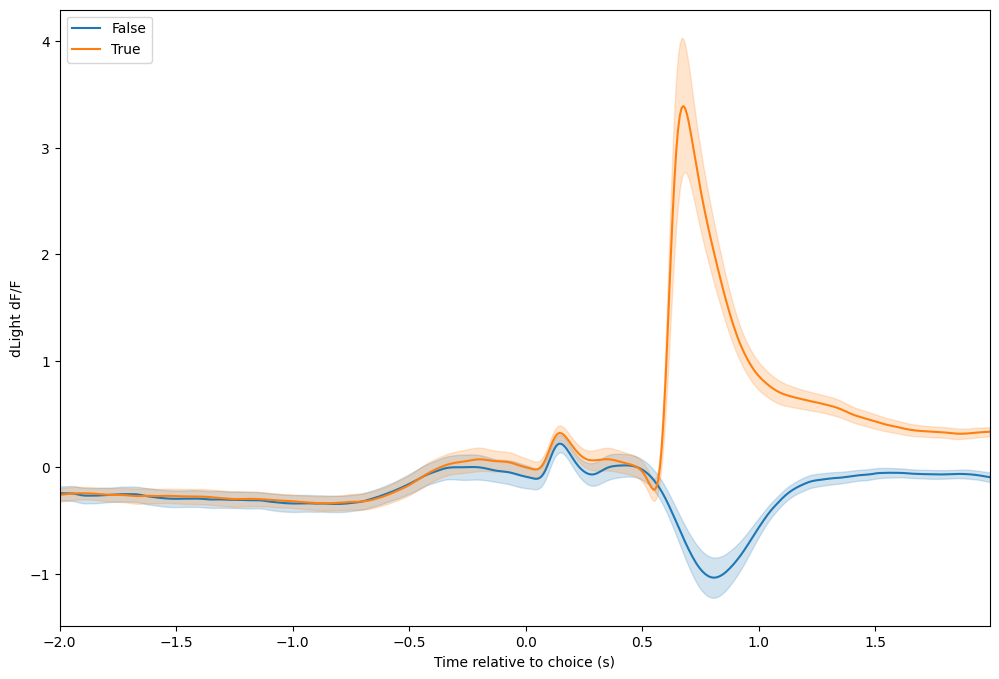

In [21]:
# Plot the response aligned to the subjects choice response with trials split by outcome.
plot_response(sessions_df, alignment="choice", hue="outcome")

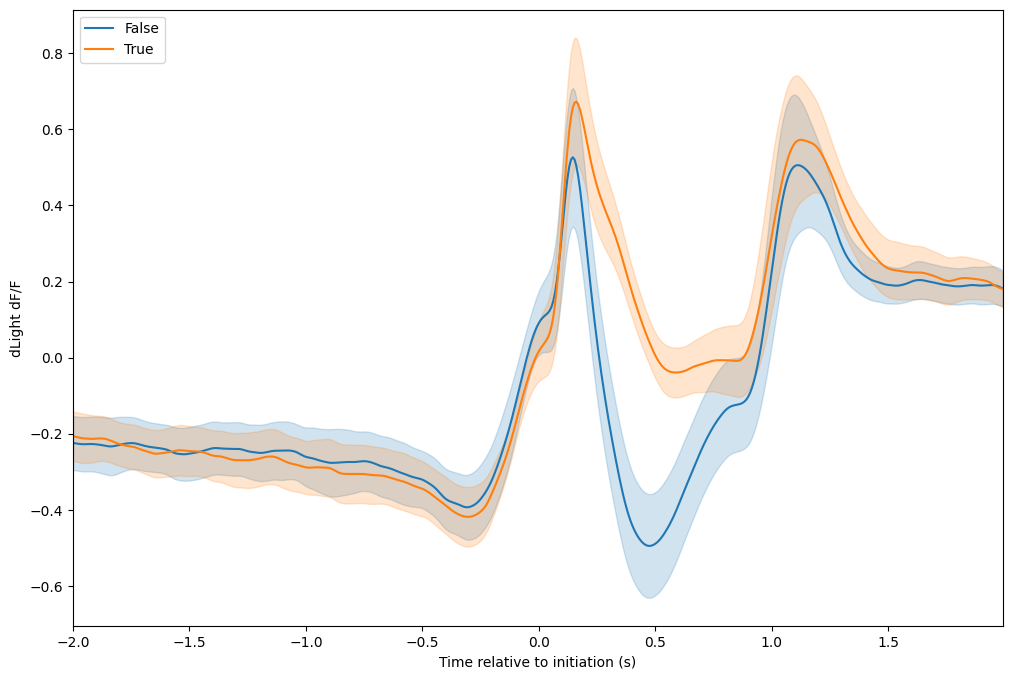

In [22]:
# Plot the response aligned to trial initiation, with trials split by contra- vs ipsilateral choice.
plot_response(sessions_df, alignment="initiation", hue="contra_choice")

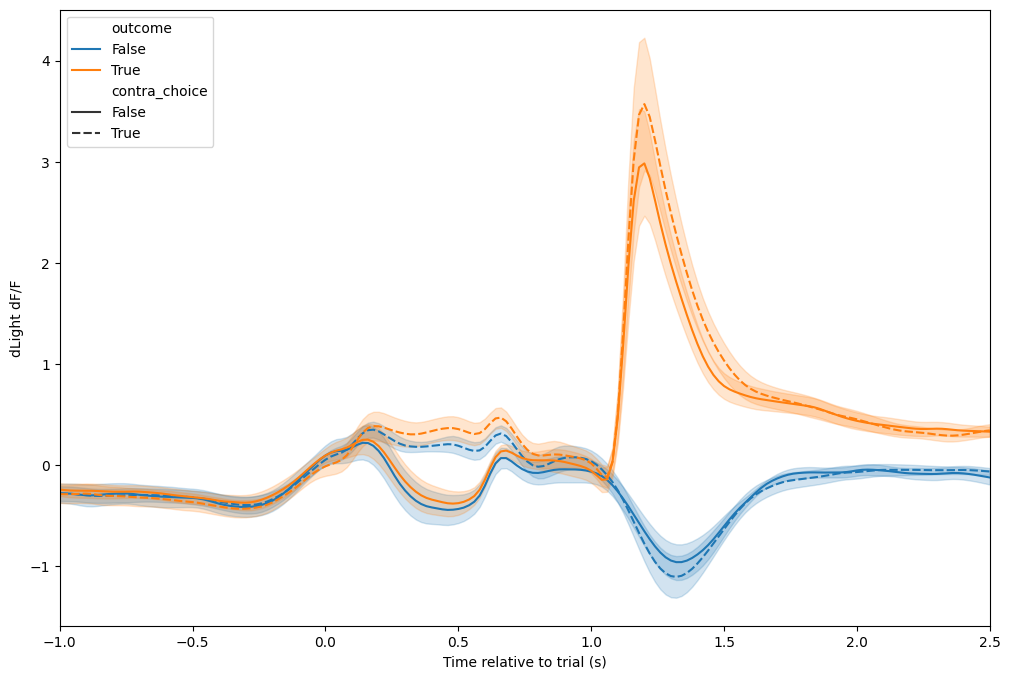

In [23]:
# Plot the response using time-warped signals to align both initiation and choice, split by both outcome and ipsi/contra choice,
# with outcome indicated by line hue and contra choice indicated by line style.
plot_response(sessions_df, alignment="trial", hue="outcome", style="contra_choice")

Linear regression is annother type of analysis that is invaluable when analysing trial by trial photometry data, as it can enable the influence of different behavioural variables on the signal to be resolved across the trial.  In the `regression_analysis` function defined below, a seperate regression analysis is run for each timepoint in the aligned signal, giving a predictor loading (beta) for each predictor at each timepoint, which can be plotted to show when and with what sign each predictor explains variance in the aligned activity.  The regression analyses are run seperately for each subject and the cross subject mean and standard error of each beta is plotted.  The set of predictors to use is specified as a string corresponding to the right hand side of a [Statsmodels Formula API](https://www.statsmodels.org/stable/example_formulas.html) formula.  Note that all the predictor names we include in this string need to be the names of columns in the `sessions_df` dataframe.

In [24]:
def regression_analysis(sessions_df, formula, alignment, style=None, sum_code=True, errorbar="se", fig_no=1):
    """Run a linear regression analysis predicting the photometry signal using predictors which vary from
    trial-to-trial.  A seperate regression analysis is run for each subject at each timepoint of the
    aligned activity.  The timecourse of the cross-subject mean beta for each predictor is plotted with
    cross subject variation indicated by shaded area.  The set of predictors used is specified using a
    string formatted according to the statsmodels formula api.
    Parameters:
        sessions_df: Dataframe generated by make_analysis_dataframe function.
        formula: String specifying the predictors to use in the regression.
        sum_code: If True binary variables are coded [-1,1] for orthogonal sum-to-zero contrasts.
        errorbar: Metric to use for cross subject variation, can be "se", "sd", or other seaborn errorbar value.
        fig_no: Figure number of plot.
    """
    timepoints = sessions_df.aligned_signal[alignment].columns
    coefs_dfs = []
    for subject in tqdm(sessions_df.subject.unique()):
        subject_df = sessions_df.loc[sessions_df.subject == subject, :]
        regression_df = subject_df.loc[:, [col for col in subject_df.columns if col[0] in formula]]
        regression_df.columns = regression_df.columns.droplevel([1, 2])
        if sum_code:
            regression_df.replace({True: 1, False: -1}, inplace=True)
        coefs = []
        for t in timepoints:
            regression_df["signal"] = subject_df.loc[:, ("aligned_signal", alignment, t)]
            fit = smf.ols(formula="signal ~ " + formula, data=regression_df).fit()
            coefs.append(fit.params)
        subject_coefs_df = pd.DataFrame(coefs)
        subject_coefs_df["time"] = timepoints
        subject_coefs_df["subject"] = subject
        if style:  # Group subjects by specified variable and differentiate by linestyle.
            assert len(subject_df[style].unique()) == 1, "Style variable must take unique value per subject."
            subject_coefs_df[style] = subject_df[style].unique()[0]
        coefs_dfs.append(subject_coefs_df)
    coefs_df = pd.concat(coefs_dfs)
    id_vars = ["subject", "time", style] if style else ["subject", "time"]
    coefs_ldf = coefs_df.melt(id_vars=id_vars, var_name="predictor", value_name="beta")
    # Compute predictor p values
    predictors = [col for col in coefs_df if col not in ("time", "subject", style)]
    pvals_df = pd.DataFrame({predictor: _predictor_pvalues(coefs_df, predictor) for predictor in predictors})
    pvals_df.index = timepoints
    # Plotting
    plt.figure(fig_no, figsize=[12, 8], clear=True)
    plt.axhline(0, color="k", linewidth=0.5)
    sns.lineplot(coefs_ldf, x="time", y="beta", hue="predictor", style=style, errorbar=errorbar)
    _plot_P_values(pvals_df, y0=plt.gca().get_ylim()[1])
    plt.xlim(coefs_ldf.time.min(), coefs_ldf.time.max())
    plt.xlabel(f"Time relative to {alignment} (s)")
    plt.ylabel("Beta (dLight dF/F)")
    plt.legend(loc="center left")


def _predictor_pvalues(coefs_df, predictor, multi_correct=True):
    """Compute P value for specified predictor at each timepoint using a ttest of the cross-subject
    distribution against 0.  If multi_correct is True Benjamini-Hochberg multiple comparison
    correction is applied to control false discovery rate."""
    predictor_df = coefs_df.loc[:, (predictor, "time", "subject")]
    predictor_df = predictor_df.pivot(columns=["time"], index="subject")
    p_values = ttest_1samp(predictor_df, 0, axis=0).pvalue
    if multi_correct:
        p_values = false_discovery_control(p_values)
    return p_values


def _plot_P_values(pvals_df, y0):
    """Indicate significance levels with dots of different sizes above plot."""
    t = pvals_df.index.to_numpy()
    for i, predictor in enumerate(pvals_df.columns):
        y = y0 * (1 + 0.04 * i)
        p_vals = pvals_df[predictor]
        t05 = t[(p_vals < 0.05) & (p_vals >= 0.01)]
        t01 = t[(p_vals < 0.01) & (p_vals >= 0.001)]
        t00 = t[p_vals < 0.001]
        plt.plot(t05, np.ones(t05.shape) * y, ".", markersize=3, color="C{}".format(i))
        plt.plot(t01, np.ones(t01.shape) * y, ".", markersize=6, color="C{}".format(i))
        plt.plot(t00, np.ones(t00.shape) * y, ".", markersize=9, color="C{}".format(i))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.51s/it]


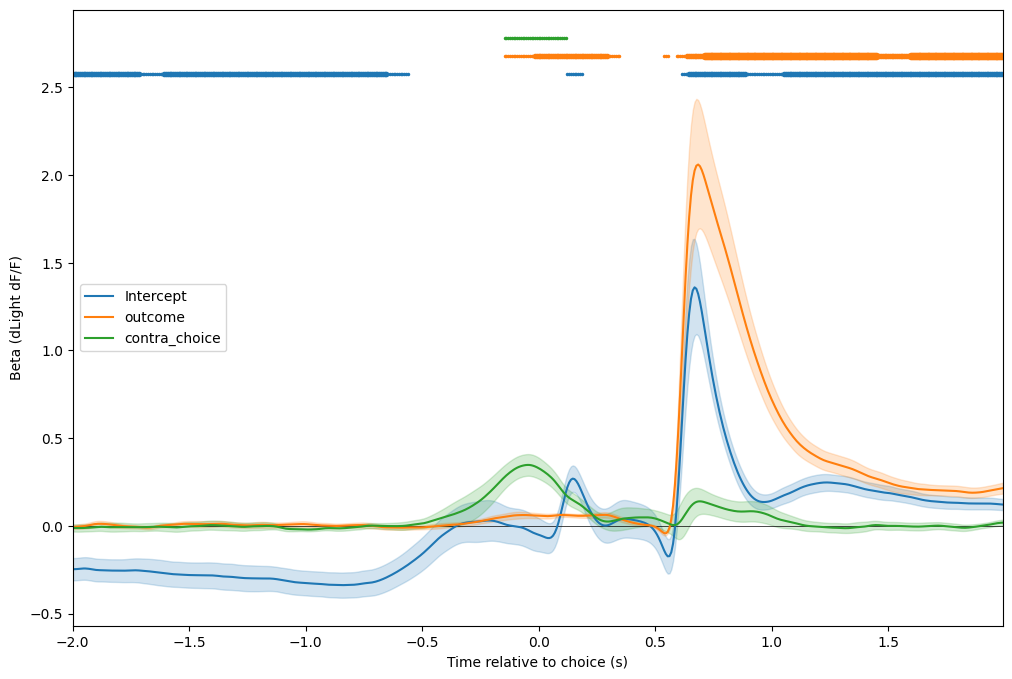

In [25]:
# Fit a regression model to the choice aligned data using trial outcome and contra/ipsi choice as predictors.
regression_analysis(sessions_df, formula="outcome + contra_choice", alignment="choice")

We can see in the above plot that there is significant loading on the outcome regressor before outcome information becomes available, because the dopamine signal is responding to the subjects expectation about the outcome.  Let's see what happens if we include an additional regressor for whether the subject chooses the correct (i.e. high reward probability option), which should be highly correlated with the subjects expectation about the trial outcome:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


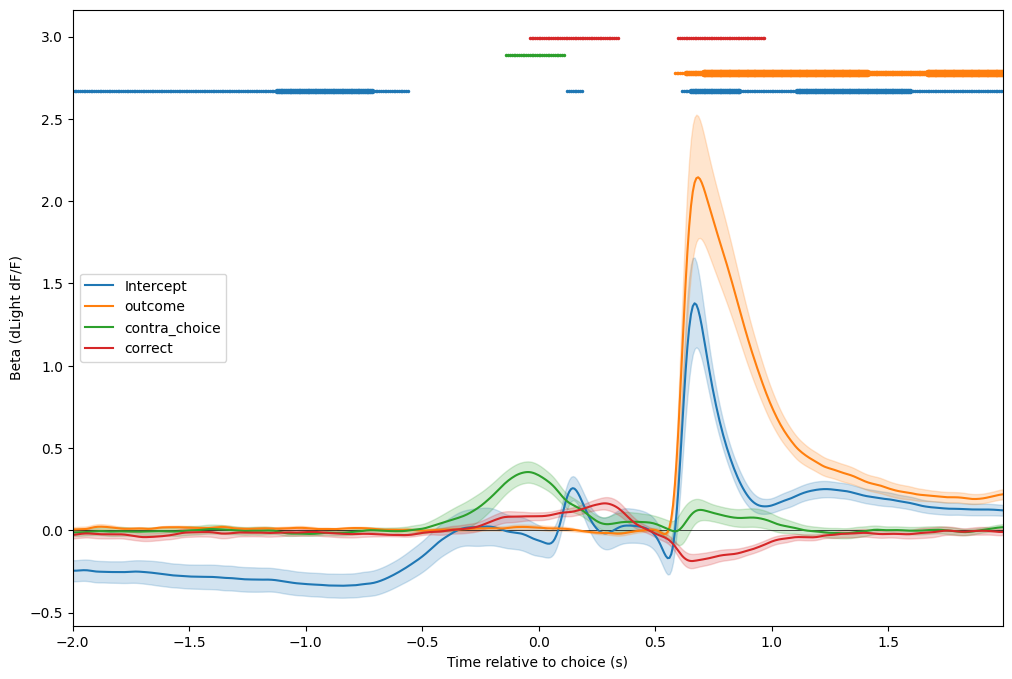

In [26]:
# Fit regression model using trial outcome, contra/ipsi choice, and correct/incorrect choice as regressors.
regression_analysis(sessions_df, formula="outcome + contra_choice + correct", alignment="choice")

We can see that including this *correct* choice predictor has removed loading on the *outcome* predictor prior to outcome information becoming available.  We can also see that the *correct* predictor has significant positive loading around the time of the choice, which then reverses sign when outcome information becomes available, consistent with reward prediction error signalling.  Finally, lets see if we can resolve an effect of the previous trial's outcome updating the value of the current trial choice, by including a predictor which codes for the previous outcome on trials where the choice is the same as on the previous trial:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.84s/it]


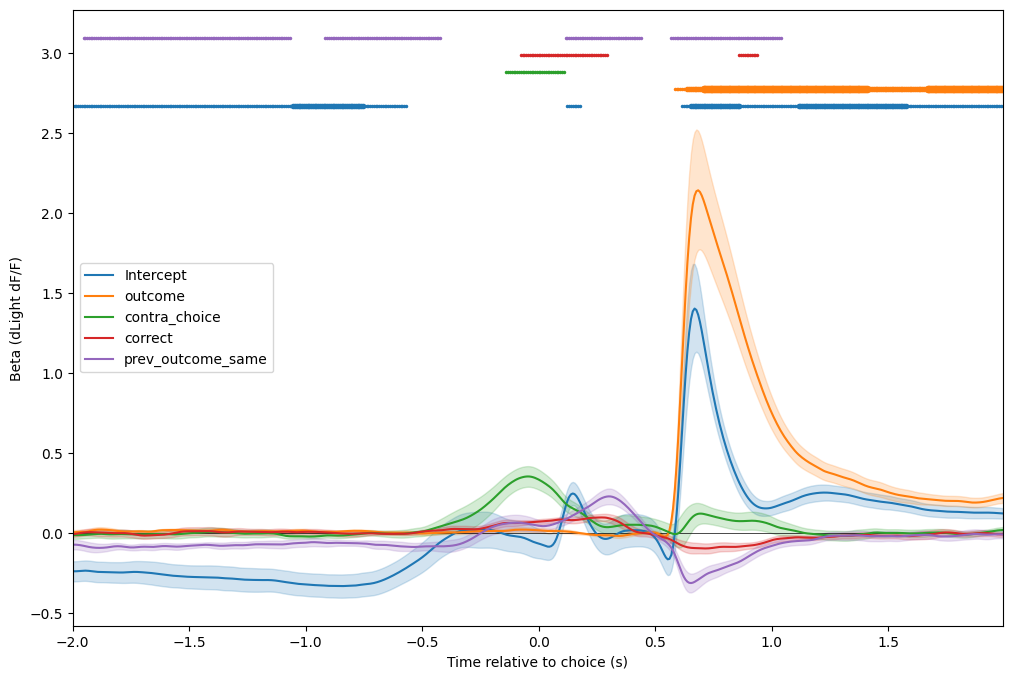

In [27]:
regression_analysis(sessions_df, formula="outcome + contra_choice + correct + prev_outcome_same", alignment="choice")

Copyright (c) Thomas Akam 2025. Licenced under the GNU General Public License v3.